In [1]:
import torch
import torch.nn as nn
import torch_geometric
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import DataLoader
from torch_geometric.utils import dense_to_sparse
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim import Adam
from matplotlib import pyplot as plt
import json
import os
from datasets import load_dataset
from sklearn.manifold import TSNE

c:\Users\Carlos\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Carlos\anaconda3\envs\pytorch\lib\site-packages\torch_geometric\typing.py:72: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not find module 'C:\Users\Carlos\anaconda3\envs\pytorch\Lib\site-packages\torch_scatter\_scatter_cuda.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "


 Similarity metrics

In [2]:
def polynomial_kernel(X, Y, degree=2, gamma=1.0, coef0=1.0):
    """
    Polynomial kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param degree: int, default=2
    :param gamma: float, default=1.0
    :param coef0: float, default=1.0
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """
    K = (gamma * torch.mm(X, Y.t()) + coef0) ** degree
    return K

def rbf_kernel(X, Y, gamma=None):

    """
    Rbf kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param gamma: float or None, default=None
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """

    if gamma == None:
        gamma = 1.0/X.size(1) # gamma = 1/n_features
    
    # K(x, y) = exp(-gamma ||x-y||^2)
    d_XY = torch.cdist(X, Y, p=2) # pairwise distances between X and Y rows. Shape = (n_samples_1, n_samples_2)
    K = torch.exp(-gamma * d_XY ** 2)

    return K

def laplacian_kernel(X, Y, gamma=None):
    """
    Laplacian kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param gamma: float or None, default=None
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """

    if gamma == None:
        gamma = 1.0/X.size(1) # gamma = 1/n_features
    
    # K(x, y) = exp(-gamma ||x-y||)
    d_XY = torch.cdist(X, Y, p=1) # pairwise distances between X and Y rows. Shape = (n_samples_1, n_samples_2)
    K = torch.exp(-gamma * d_XY)

    return K

def sigmoid_kernel(X, Y, gamma=1.0, coef0=1.0):
    """
    Sigmoid kernel function.
    :param X: torch.Tensor of shape (n_samples_1, n_features)
    :param Y: torch.Tensor of shape (n_samples_2, n_features)
    :param gamma: float, default=1.0
    :param coef0: float, default=1.0
    :return: torch.Tensor of shape (n_samples_1, n_samples_2)
    """
    K = torch.tanh(gamma * torch.mm(X, Y.t()) + coef0)
    return K

In [3]:
def binary_distance(X, Y):
    """Compute distance matrix between  rows of X, Y.

    d(x_i, y_j) = 1 if x_i == y_j, 0 in other case.

    for all rows x_i in X, y_j in Y

    """
    return (X.unsqueeze(1) == Y.unsqueeze(0)).all(-1).float()


def kernel(X, *args, **kwargs):
    """
    Compute similarity matrix of an array X using a variety of kernels
    Parameters:
        X = input data (torch.Tensor or numpy array)
    """
    # kernel parameters

    degree = kwargs.get("degree", None)
    gamma = kwargs.get("gamma", None)
    coef = kwargs.get("coef", None)
    kernel_type = kwargs.get("kernel_type", None)

    if kernel_type == "polynomial":


        # K(x,y) = (gamma * <x,y> + coef)^degree, for vectors x,y

        if (gamma != None) & (coef != None) & (degree != None):
            return polynomial_kernel(X = X, Y = X, degree = degree, gamma = gamma, coef0 = coef)
        else:
            return None

    elif kernel_type == "sigmoid":
 
        # K(x,y) = tanh(gamma * <x,y> + coef), for vectors x,y

        if (gamma != None) & (coef != None):
            return sigmoid_kernel(X = X, Y = X, gamma = gamma, coef0 = coef)
        else:
            return None

    elif kernel_type == "rbf":

        # K(x, y) = exp(-gamma ||x-y||^2)

        if (gamma != None):
            return rbf_kernel(X = X, Y = X, gamma = gamma)
        else:
            return None

    elif kernel_type == "laplacian":

        # K(x, y) = exp(-gamma ||x-y||_1)

        if (gamma != None):
            return laplacian_kernel(X = X, Y = X, gamma = gamma)
        else:
            return None

    else:
        return None


Model definition

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_size, latent_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, latent_size)
        self.activation = nn.ReLU()
    def forward(self, x):
        x = self.activation(self.layer1(x))
        x = self.activation(self.layer2(x))
        x = self.activation(self.layer3(x))
        return x

class Decoder(nn.Module):

    def __init__(self, latent_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(latent_size, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, output_size)
        self.activation = nn.ReLU()

    def forward(self, z):
        z = self.activation(self.layer1(z))
        z = self.activation(self.layer2(z))
        z = self.activation(self.layer3(z))
        return z

class GAE(nn.Module):

    def __init__(self, encoder, decoder, kernel_parameters_X, optimizer, criterion, label_indep = False, kernel_parameters_Y = None, lam=0.3):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.kernel_parameters_X = kernel_parameters_X
        self.kernel_parameters_Y = kernel_parameters_Y
        self.label_indep = label_indep
        self.optimizer = optimizer
        self.criterion = criterion
        self.lam = lam

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def train_model(self, data_loader):
        self.train()

        epoch_losses = [] # log of each minibatch loss
        sup_losses = []
        recon_losses = []

        for X, y in tqdm(data_loader):
            self.optimizer.zero_grad()

            K_X = kernel(X, **self.kernel_parameters_X)

            if self.label_indep: # data with different labels has not relationship (e.g: multiclass classification)
                K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))

            else:
                if self.kernel_parameters_Y == None:
                    self.kernel_parameters_Y = self.kernel_parameters_X

                K_Y = kernel(y, **self.kernel_parameters_Y)

            K_XY = K_X * K_Y # joint similarity matrix

            Z = self.encode(X)
            distance_matrix = torch.cdist(Z, Z, p=2)
            out = self.decode(Z) 
            sup_loss = torch.sum(K_XY * distance_matrix)
            recon_loss = self.criterion(out, X)
            loss = self.lam * sup_loss + (1-self.lam) * recon_loss

            epoch_losses.append(loss)
            sup_losses.append(sup_loss)
            recon_losses.append(recon_loss)

            loss.backward()
            self.optimizer.step()

        avg_loss = torch.mean(torch.Tensor(epoch_losses))
        avg_sup_loss = torch.mean(torch.Tensor(sup_losses))
        avg_recon_loss = torch.mean(torch.Tensor(recon_losses))

        return avg_loss.item(), avg_sup_loss.item(), avg_recon_loss.item()

    def test_model(self, data_loader):
        self.eval()
        epoch_losses = []
        sup_losses = []
        recon_losses = []

        with torch.no_grad():
            for X, y in data_loader:
                K_X = kernel(X, **self.kernel_parameters_X)

                if self.label_indep: # data with different labels has not relationship (e.g: multiclass classification)
                    K_Y = binary_distance(y.unsqueeze(1), y.unsqueeze(1))

                else:
                    if self.kernel_parameters_Y == None:
                        self.kernel_parameters_Y = self.kernel_parameters_X

                    K_Y = kernel(y, **self.kernel_parameters_Y)

                K_XY = K_X * K_Y # joint similarity matrix

                Z = self.encode(X)
                distance_matrix = torch.cdist(Z, Z, p=2)
                out = self.decode(Z)

                sup_loss = torch.sum(K_XY * distance_matrix)
                recon_loss = self.criterion(out, X)
                loss = self.lam * sup_loss + (1-self.lam) * recon_loss

                epoch_losses.append(loss)
                sup_losses.append(sup_loss)
                recon_losses.append(recon_loss)

        avg_loss = torch.mean(torch.Tensor(epoch_losses))
        avg_sup_loss = torch.mean(torch.Tensor(sup_losses))
        avg_recon_loss = torch.mean(torch.Tensor(recon_losses))
        
        return avg_loss.item(), avg_sup_loss.item(), avg_recon_loss.item()
    

Model hyperparameters

In [5]:
lr = 0.0001 # learning rate
batch_size = 256
epochs = 200
latent_size = 64 # latent space dimension

kernel_param_X = {

    "kernel_type": "rbf",
    "degree": 3,
    "gamma": 5,
    "coef": 0

}

# kernel function parameters for Y_train / Y_test. If is equal to None, we use the same parameters.

kernel_param_Y = None

"""
kernel_param_Y = {

    "kernel_type": "polynomial",
    "degree": 3,
    "gamma": 1.,
    "coef": 1.

}
"""

label_indep = True # True for categoric labels, False for numerical labels

CIFAR10 Fashion preprocessing

In [6]:
def create_cifar_10_dataset(dataset):
    df = pd.DataFrame(dataset)
    img_array = np.stack(df["img"].apply(lambda x: np.array(x).flatten()))
    columns = [f"pixel_{i}" for i in range(img_array.shape[1])]
    labels = pd.DataFrame(df["label"], columns = ["label"])
    df = pd.DataFrame(img_array, columns = columns)
    df = pd.concat([df, labels], axis = 1)
    return df

# load CIFAR10 dataset and process it as a dataframe with pixel values and labels

data = load_dataset("cifar10")

train_data = create_cifar_10_dataset(data["train"])
test_data = create_cifar_10_dataset(data["test"])

train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42, shuffle=True, stratify=train_data["label"])

X_train = train_data.drop("label", axis = 1)/255.
y_train = train_data["label"]
X_train = torch.tensor(X_train.values, dtype=torch.float)
y_train = torch.tensor(y_train.values, dtype=torch.float)
X_val = val_data.drop("label", axis=1)/255.
X_val = torch.tensor(X_val.values, dtype=torch.float)
y_val = val_data["label"]
y_val = torch.tensor(y_val.values, dtype=torch.float)
X_test = test_data.drop("label", axis=1)/255.
X_test = torch.tensor(X_test.values, dtype=torch.float)
y_test = test_data["label"]
y_test = torch.tensor(y_test.values, dtype=torch.float)

train_loader = DataLoader(list(zip(X_train, y_train)), shuffle = True, batch_size=batch_size)
val_loader = DataLoader(list(zip(X_val, y_val)), shuffle = True, batch_size=batch_size)
test_loader = DataLoader(list(zip(X_test, y_test)), shuffle = False, batch_size=batch_size)
input_size = X_train.size(1)

Model creation

In [7]:
model_encoder = Encoder(input_size, latent_size)
model_decoder = Decoder(latent_size, input_size)
optimizer = Adam(list(model_encoder.parameters()) + list(model_decoder.parameters()), lr = lr)
criterion = nn.MSELoss()
model = GAE(model_encoder, model_decoder, kernel_param_X, optimizer, criterion, label_indep, kernel_param_Y, lam=0.95)


Model training

In [8]:
for epoch in range(epochs):
    print(f"Epoch: {epoch + 1}/{epochs}")
    avg_loss_train, avg_sup_loss_train, avg_recon_loss_train = model.train_model(train_loader)
    avg_loss_val, avg_sup_loss_val, avg_recon_loss_val = model.test_model(val_loader)

    print(f"avg_loss_train: {avg_loss_train:.4f}, avg_sup_loss_train: {avg_sup_loss_train:.4f}, avg_recon_loss_train: {avg_recon_loss_train:.4f}")
    print(f"avg_loss_val: {avg_loss_val:.4f}, avg_sup_loss_val: {avg_sup_loss_val:.4f}, avg_recon_loss_val: {avg_recon_loss_val:.4f}")


Epoch: 1/200


100%|██████████| 176/176 [00:11<00:00, 15.48it/s]


avg_loss_train: 0.4561, avg_sup_loss_train: 0.4723, avg_recon_loss_train: 0.1481
avg_loss_val: 0.4952, avg_sup_loss_val: 0.5146, avg_recon_loss_val: 0.1274
Epoch: 2/200


100%|██████████| 176/176 [00:10<00:00, 16.27it/s]


avg_loss_train: 0.5234, avg_sup_loss_train: 0.5451, avg_recon_loss_train: 0.1113
avg_loss_val: 0.5206, avg_sup_loss_val: 0.5429, avg_recon_loss_val: 0.0968
Epoch: 3/200


100%|██████████| 176/176 [00:11<00:00, 15.90it/s]


avg_loss_train: 0.5685, avg_sup_loss_train: 0.5940, avg_recon_loss_train: 0.0839
avg_loss_val: 0.5701, avg_sup_loss_val: 0.5960, avg_recon_loss_val: 0.0773
Epoch: 4/200


100%|██████████| 176/176 [00:11<00:00, 15.83it/s]


avg_loss_train: 0.6177, avg_sup_loss_train: 0.6466, avg_recon_loss_train: 0.0686
avg_loss_val: 0.6590, avg_sup_loss_val: 0.6903, avg_recon_loss_val: 0.0630
Epoch: 5/200


100%|██████████| 176/176 [00:11<00:00, 15.69it/s]


avg_loss_train: 0.7053, avg_sup_loss_train: 0.7395, avg_recon_loss_train: 0.0565
avg_loss_val: 0.7239, avg_sup_loss_val: 0.7592, avg_recon_loss_val: 0.0517
Epoch: 6/200


100%|██████████| 176/176 [00:11<00:00, 15.81it/s]


avg_loss_train: 0.7689, avg_sup_loss_train: 0.8068, avg_recon_loss_train: 0.0482
avg_loss_val: 0.8105, avg_sup_loss_val: 0.8507, avg_recon_loss_val: 0.0468
Epoch: 7/200


100%|██████████| 176/176 [00:11<00:00, 15.43it/s]


avg_loss_train: 0.8192, avg_sup_loss_train: 0.8600, avg_recon_loss_train: 0.0446
avg_loss_val: 0.8106, avg_sup_loss_val: 0.8510, avg_recon_loss_val: 0.0434
Epoch: 8/200


100%|██████████| 176/176 [00:11<00:00, 15.87it/s]


avg_loss_train: 0.8718, avg_sup_loss_train: 0.9155, avg_recon_loss_train: 0.0415
avg_loss_val: 0.8886, avg_sup_loss_val: 0.9332, avg_recon_loss_val: 0.0407
Epoch: 9/200


100%|██████████| 176/176 [00:11<00:00, 15.75it/s]


avg_loss_train: 0.9154, avg_sup_loss_train: 0.9616, avg_recon_loss_train: 0.0388
avg_loss_val: 0.8890, avg_sup_loss_val: 0.9338, avg_recon_loss_val: 0.0379
Epoch: 10/200


100%|██████████| 176/176 [00:11<00:00, 15.01it/s]


avg_loss_train: 0.9656, avg_sup_loss_train: 1.0145, avg_recon_loss_train: 0.0368
avg_loss_val: 0.9570, avg_sup_loss_val: 1.0055, avg_recon_loss_val: 0.0367
Epoch: 11/200


100%|██████████| 176/176 [00:11<00:00, 15.83it/s]


avg_loss_train: 0.9907, avg_sup_loss_train: 1.0409, avg_recon_loss_train: 0.0355
avg_loss_val: 0.9955, avg_sup_loss_val: 1.0460, avg_recon_loss_val: 0.0353
Epoch: 12/200


100%|██████████| 176/176 [00:11<00:00, 15.35it/s]


avg_loss_train: 1.0121, avg_sup_loss_train: 1.0635, avg_recon_loss_train: 0.0343
avg_loss_val: 1.0210, avg_sup_loss_val: 1.0730, avg_recon_loss_val: 0.0343
Epoch: 13/200


100%|██████████| 176/176 [00:11<00:00, 14.83it/s]


avg_loss_train: 1.0520, avg_sup_loss_train: 1.1057, avg_recon_loss_train: 0.0332
avg_loss_val: 1.0584, avg_sup_loss_val: 1.1124, avg_recon_loss_val: 0.0332
Epoch: 14/200


100%|██████████| 176/176 [00:11<00:00, 15.13it/s]


avg_loss_train: 1.0856, avg_sup_loss_train: 1.1410, avg_recon_loss_train: 0.0324
avg_loss_val: 1.0806, avg_sup_loss_val: 1.1358, avg_recon_loss_val: 0.0323
Epoch: 15/200


100%|██████████| 176/176 [00:11<00:00, 15.33it/s]


avg_loss_train: 1.0930, avg_sup_loss_train: 1.1489, avg_recon_loss_train: 0.0316
avg_loss_val: 1.0754, avg_sup_loss_val: 1.1303, avg_recon_loss_val: 0.0317
Epoch: 16/200


100%|██████████| 176/176 [00:11<00:00, 15.05it/s]


avg_loss_train: 1.1078, avg_sup_loss_train: 1.1644, avg_recon_loss_train: 0.0311
avg_loss_val: 1.0724, avg_sup_loss_val: 1.1272, avg_recon_loss_val: 0.0312
Epoch: 17/200


100%|██████████| 176/176 [00:12<00:00, 14.57it/s]


avg_loss_train: 1.1318, avg_sup_loss_train: 1.1898, avg_recon_loss_train: 0.0305
avg_loss_val: 1.1521, avg_sup_loss_val: 1.2111, avg_recon_loss_val: 0.0307
Epoch: 18/200


100%|██████████| 176/176 [00:11<00:00, 15.54it/s]


avg_loss_train: 1.1273, avg_sup_loss_train: 1.1851, avg_recon_loss_train: 0.0299
avg_loss_val: 1.1112, avg_sup_loss_val: 1.1681, avg_recon_loss_val: 0.0301
Epoch: 19/200


100%|██████████| 176/176 [00:11<00:00, 15.16it/s]


avg_loss_train: 1.1582, avg_sup_loss_train: 1.2176, avg_recon_loss_train: 0.0295
avg_loss_val: 1.1318, avg_sup_loss_val: 1.1899, avg_recon_loss_val: 0.0297
Epoch: 20/200


100%|██████████| 176/176 [00:11<00:00, 15.52it/s]


avg_loss_train: 1.1726, avg_sup_loss_train: 1.2328, avg_recon_loss_train: 0.0293
avg_loss_val: 1.1358, avg_sup_loss_val: 1.1941, avg_recon_loss_val: 0.0294
Epoch: 21/200


100%|██████████| 176/176 [00:11<00:00, 15.38it/s]


avg_loss_train: 1.1585, avg_sup_loss_train: 1.2180, avg_recon_loss_train: 0.0288
avg_loss_val: 1.1889, avg_sup_loss_val: 1.2499, avg_recon_loss_val: 0.0290
Epoch: 22/200


100%|██████████| 176/176 [00:11<00:00, 15.64it/s]


avg_loss_train: 1.1898, avg_sup_loss_train: 1.2510, avg_recon_loss_train: 0.0284
avg_loss_val: 1.1681, avg_sup_loss_val: 1.2280, avg_recon_loss_val: 0.0285
Epoch: 23/200


100%|██████████| 176/176 [00:11<00:00, 15.79it/s]


avg_loss_train: 1.1979, avg_sup_loss_train: 1.2595, avg_recon_loss_train: 0.0280
avg_loss_val: 1.1845, avg_sup_loss_val: 1.2454, avg_recon_loss_val: 0.0282
Epoch: 24/200


100%|██████████| 176/176 [00:11<00:00, 15.59it/s]


avg_loss_train: 1.1925, avg_sup_loss_train: 1.2538, avg_recon_loss_train: 0.0277
avg_loss_val: 1.1848, avg_sup_loss_val: 1.2457, avg_recon_loss_val: 0.0279
Epoch: 25/200


100%|██████████| 176/176 [00:11<00:00, 15.21it/s]


avg_loss_train: 1.2189, avg_sup_loss_train: 1.2816, avg_recon_loss_train: 0.0273
avg_loss_val: 1.1684, avg_sup_loss_val: 1.2285, avg_recon_loss_val: 0.0275
Epoch: 26/200


100%|██████████| 176/176 [00:11<00:00, 14.76it/s]


avg_loss_train: 1.2252, avg_sup_loss_train: 1.2883, avg_recon_loss_train: 0.0271
avg_loss_val: 1.1990, avg_sup_loss_val: 1.2607, avg_recon_loss_val: 0.0274
Epoch: 27/200


100%|██████████| 176/176 [00:11<00:00, 15.24it/s]


avg_loss_train: 1.2316, avg_sup_loss_train: 1.2950, avg_recon_loss_train: 0.0268
avg_loss_val: 1.2553, avg_sup_loss_val: 1.3199, avg_recon_loss_val: 0.0271
Epoch: 28/200


100%|██████████| 176/176 [00:11<00:00, 15.22it/s]


avg_loss_train: 1.2312, avg_sup_loss_train: 1.2946, avg_recon_loss_train: 0.0266
avg_loss_val: 1.2144, avg_sup_loss_val: 1.2769, avg_recon_loss_val: 0.0268
Epoch: 29/200


100%|██████████| 176/176 [00:11<00:00, 15.52it/s]


avg_loss_train: 1.2467, avg_sup_loss_train: 1.3110, avg_recon_loss_train: 0.0264
avg_loss_val: 1.2362, avg_sup_loss_val: 1.2999, avg_recon_loss_val: 0.0266
Epoch: 30/200


100%|██████████| 176/176 [00:11<00:00, 15.72it/s]


avg_loss_train: 1.2550, avg_sup_loss_train: 1.3197, avg_recon_loss_train: 0.0262
avg_loss_val: 1.2691, avg_sup_loss_val: 1.3345, avg_recon_loss_val: 0.0264
Epoch: 31/200


100%|██████████| 176/176 [00:11<00:00, 15.60it/s]


avg_loss_train: 1.2574, avg_sup_loss_train: 1.3222, avg_recon_loss_train: 0.0259
avg_loss_val: 1.2249, avg_sup_loss_val: 1.2879, avg_recon_loss_val: 0.0262
Epoch: 32/200


100%|██████████| 176/176 [00:11<00:00, 14.90it/s]


avg_loss_train: 1.2786, avg_sup_loss_train: 1.3446, avg_recon_loss_train: 0.0258
avg_loss_val: 1.2261, avg_sup_loss_val: 1.2893, avg_recon_loss_val: 0.0261
Epoch: 33/200


100%|██████████| 176/176 [00:11<00:00, 15.49it/s]


avg_loss_train: 1.2767, avg_sup_loss_train: 1.3426, avg_recon_loss_train: 0.0256
avg_loss_val: 1.2541, avg_sup_loss_val: 1.3187, avg_recon_loss_val: 0.0259
Epoch: 34/200


100%|██████████| 176/176 [00:11<00:00, 15.60it/s]


avg_loss_train: 1.2601, avg_sup_loss_train: 1.3251, avg_recon_loss_train: 0.0254
avg_loss_val: 1.2493, avg_sup_loss_val: 1.3137, avg_recon_loss_val: 0.0256
Epoch: 35/200


100%|██████████| 176/176 [00:11<00:00, 15.74it/s]


avg_loss_train: 1.2786, avg_sup_loss_train: 1.3446, avg_recon_loss_train: 0.0252
avg_loss_val: 1.2561, avg_sup_loss_val: 1.3209, avg_recon_loss_val: 0.0254
Epoch: 36/200


100%|██████████| 176/176 [00:11<00:00, 15.73it/s]


avg_loss_train: 1.2970, avg_sup_loss_train: 1.3639, avg_recon_loss_train: 0.0250
avg_loss_val: 1.2663, avg_sup_loss_val: 1.3316, avg_recon_loss_val: 0.0252
Epoch: 37/200


100%|██████████| 176/176 [00:11<00:00, 15.75it/s]


avg_loss_train: 1.2784, avg_sup_loss_train: 1.3443, avg_recon_loss_train: 0.0248
avg_loss_val: 1.2743, avg_sup_loss_val: 1.3400, avg_recon_loss_val: 0.0251
Epoch: 38/200


100%|██████████| 176/176 [00:11<00:00, 15.38it/s]


avg_loss_train: 1.3011, avg_sup_loss_train: 1.3683, avg_recon_loss_train: 0.0247
avg_loss_val: 1.2836, avg_sup_loss_val: 1.3499, avg_recon_loss_val: 0.0250
Epoch: 39/200


100%|██████████| 176/176 [00:11<00:00, 14.85it/s]


avg_loss_train: 1.2962, avg_sup_loss_train: 1.3631, avg_recon_loss_train: 0.0246
avg_loss_val: 1.2365, avg_sup_loss_val: 1.3003, avg_recon_loss_val: 0.0248
Epoch: 40/200


100%|██████████| 176/176 [00:11<00:00, 15.48it/s]


avg_loss_train: 1.3064, avg_sup_loss_train: 1.3738, avg_recon_loss_train: 0.0244
avg_loss_val: 1.3463, avg_sup_loss_val: 1.4158, avg_recon_loss_val: 0.0246
Epoch: 41/200


100%|██████████| 176/176 [00:11<00:00, 14.90it/s]


avg_loss_train: 1.2968, avg_sup_loss_train: 1.3638, avg_recon_loss_train: 0.0242
avg_loss_val: 1.3028, avg_sup_loss_val: 1.3701, avg_recon_loss_val: 0.0245
Epoch: 42/200


100%|██████████| 176/176 [00:11<00:00, 15.23it/s]


avg_loss_train: 1.3345, avg_sup_loss_train: 1.4035, avg_recon_loss_train: 0.0241
avg_loss_val: 1.3673, avg_sup_loss_val: 1.4380, avg_recon_loss_val: 0.0244
Epoch: 43/200


100%|██████████| 176/176 [00:11<00:00, 15.83it/s]


avg_loss_train: 1.3077, avg_sup_loss_train: 1.3753, avg_recon_loss_train: 0.0240
avg_loss_val: 1.2997, avg_sup_loss_val: 1.3668, avg_recon_loss_val: 0.0242
Epoch: 44/200


100%|██████████| 176/176 [00:12<00:00, 13.68it/s]


avg_loss_train: 1.3262, avg_sup_loss_train: 1.3948, avg_recon_loss_train: 0.0239
avg_loss_val: 1.3091, avg_sup_loss_val: 1.3767, avg_recon_loss_val: 0.0241
Epoch: 45/200


100%|██████████| 176/176 [00:12<00:00, 14.27it/s]


avg_loss_train: 1.3222, avg_sup_loss_train: 1.3906, avg_recon_loss_train: 0.0237
avg_loss_val: 1.3298, avg_sup_loss_val: 1.3985, avg_recon_loss_val: 0.0240
Epoch: 46/200


100%|██████████| 176/176 [00:11<00:00, 14.69it/s]


avg_loss_train: 1.3290, avg_sup_loss_train: 1.3977, avg_recon_loss_train: 0.0236
avg_loss_val: 1.3050, avg_sup_loss_val: 1.3724, avg_recon_loss_val: 0.0239
Epoch: 47/200


100%|██████████| 176/176 [00:11<00:00, 15.49it/s]


avg_loss_train: 1.3391, avg_sup_loss_train: 1.4084, avg_recon_loss_train: 0.0236
avg_loss_val: 1.3096, avg_sup_loss_val: 1.3773, avg_recon_loss_val: 0.0239
Epoch: 48/200


100%|██████████| 176/176 [00:11<00:00, 15.32it/s]


avg_loss_train: 1.3206, avg_sup_loss_train: 1.3889, avg_recon_loss_train: 0.0235
avg_loss_val: 1.2742, avg_sup_loss_val: 1.3400, avg_recon_loss_val: 0.0237
Epoch: 49/200


100%|██████████| 176/176 [00:11<00:00, 15.08it/s]


avg_loss_train: 1.3398, avg_sup_loss_train: 1.4090, avg_recon_loss_train: 0.0233
avg_loss_val: 1.3201, avg_sup_loss_val: 1.3884, avg_recon_loss_val: 0.0236
Epoch: 50/200


100%|██████████| 176/176 [00:11<00:00, 15.67it/s]


avg_loss_train: 1.3431, avg_sup_loss_train: 1.4126, avg_recon_loss_train: 0.0233
avg_loss_val: 1.3388, avg_sup_loss_val: 1.4080, avg_recon_loss_val: 0.0236
Epoch: 51/200


100%|██████████| 176/176 [00:11<00:00, 15.68it/s]


avg_loss_train: 1.3401, avg_sup_loss_train: 1.4094, avg_recon_loss_train: 0.0232
avg_loss_val: 1.3065, avg_sup_loss_val: 1.3741, avg_recon_loss_val: 0.0235
Epoch: 52/200


100%|██████████| 176/176 [00:11<00:00, 15.76it/s]


avg_loss_train: 1.3284, avg_sup_loss_train: 1.3971, avg_recon_loss_train: 0.0232
avg_loss_val: 1.3602, avg_sup_loss_val: 1.4306, avg_recon_loss_val: 0.0235
Epoch: 53/200


100%|██████████| 176/176 [00:11<00:00, 15.28it/s]


avg_loss_train: 1.3561, avg_sup_loss_train: 1.4263, avg_recon_loss_train: 0.0231
avg_loss_val: 1.3335, avg_sup_loss_val: 1.4025, avg_recon_loss_val: 0.0234
Epoch: 54/200


100%|██████████| 176/176 [00:11<00:00, 15.98it/s]


avg_loss_train: 1.3522, avg_sup_loss_train: 1.4222, avg_recon_loss_train: 0.0230
avg_loss_val: 1.3466, avg_sup_loss_val: 1.4162, avg_recon_loss_val: 0.0234
Epoch: 55/200


100%|██████████| 176/176 [00:11<00:00, 15.30it/s]


avg_loss_train: 1.3426, avg_sup_loss_train: 1.4120, avg_recon_loss_train: 0.0230
avg_loss_val: 1.3358, avg_sup_loss_val: 1.4048, avg_recon_loss_val: 0.0234
Epoch: 56/200


100%|██████████| 176/176 [00:11<00:00, 15.93it/s]


avg_loss_train: 1.3512, avg_sup_loss_train: 1.4211, avg_recon_loss_train: 0.0230
avg_loss_val: 1.3521, avg_sup_loss_val: 1.4221, avg_recon_loss_val: 0.0233
Epoch: 57/200


 24%|██▍       | 42/176 [00:02<00:08, 15.04it/s]


KeyboardInterrupt: 

Model testing

In [9]:
model.test_model(test_loader)

(1.318860411643982, 1.3870521783828735, 0.02322082780301571)

In [10]:
for X, y in test_loader:
    Z = model.encode(X)
    out = model.decode(Z)

    break

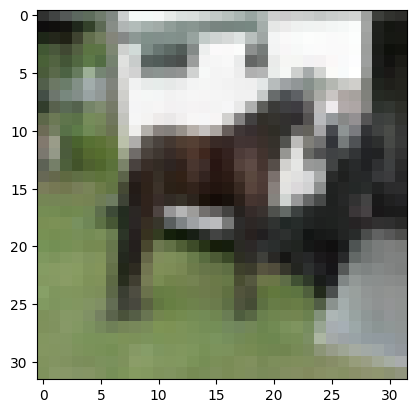

In [24]:
data_number = 20
prueba = X[data_number].detach().numpy().reshape(32, 32, 3)
plt.imshow(prueba, cmap = "gray")

In [12]:
y[data_number]

tensor(4.)

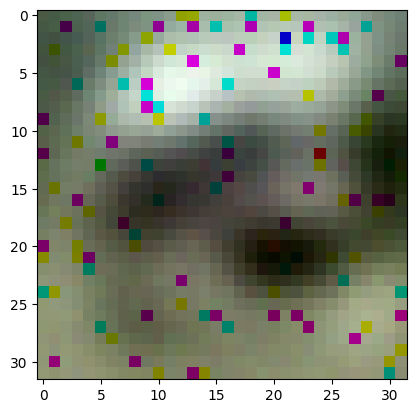

In [25]:
prueba_out = out[data_number].detach().numpy().reshape(32, 32, 3)
plt.imshow(prueba_out, cmap = "gray")

2D embedding representation with t-SNE

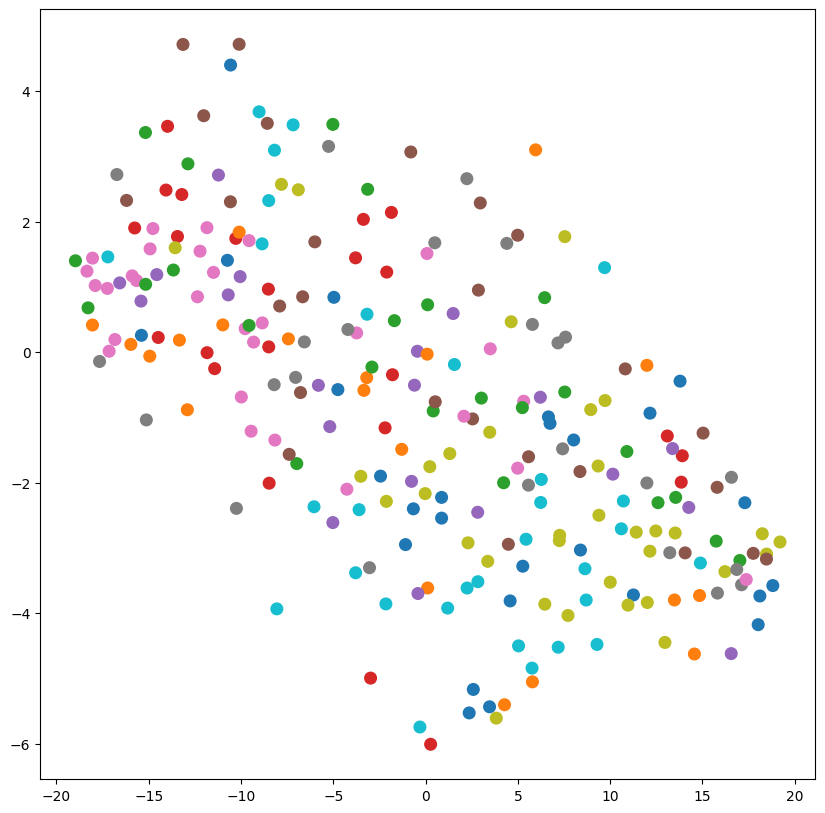

In [23]:
img = TSNE(n_components=2).fit_transform(Z.detach().numpy())
plt.figure(figsize=(10,10))

plt.scatter(img[:, 0], img[:, 1], s=70,  c=y, cmap='tab10')
plt.show()

Training a MLP for classification with embeddings of the previous GNN model

In [20]:
class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, num_hidden_layers, output_size, lr, criterion, use_embeddings = True):
    super().__init__()
    
    self.criterion = criterion
    activation = nn.ReLU()
    self.MLP_layers = nn.ModuleList()
    layer = nn.Linear(input_size, hidden_size)
    nn.init.xavier_uniform(layer.weight)
    layer.bias.data.fill_(0.01)
    self.MLP_layers.append(layer)
    self.MLP_layers.append(activation)
    self.use_embeddings = use_embeddings

    for _ in range(num_hidden_layers - 1):

      layer = nn.Linear(hidden_size, hidden_size)
      nn.init.xavier_uniform(layer.weight)
      layer.bias.data.fill_(0.01)
      self.MLP_layers.append(layer)
      self.MLP_layers.append(activation)

    layer = nn.Linear(hidden_size, output_size)
    nn.init.xavier_uniform(layer.weight)
    layer.bias.data.fill_(0.01)
    self.MLP_layers.append(layer)
    self.MLP_layers.append(nn.Sigmoid())

    self.optimizer = Adam(self.parameters(), lr)

  def forward(self, x):
    for layer in self.MLP_layers:
      x = layer(x)

    return x
  
  def train_model(self, train_loader):

    self.train()

    epoch_losses = []
    epoch_accuracies = []

    for X, y in tqdm(train_loader):

      self.optimizer.zero_grad()
      if self.use_embeddings:
        with torch.no_grad():
          Z = model.encode(X)
        out = self.forward(Z)
      else:
        out = self.forward(X)
      
      loss = self.criterion(out, y.long())
      preds = torch.argmax(out, dim = 1)
      accuracy = torch.mean((preds == y.long()).float())
      epoch_losses.append(loss)
      epoch_accuracies.append(accuracy)
      loss.backward()
      self.optimizer.step()

    avg_loss = torch.mean(torch.Tensor(epoch_losses))
    avg_accuracy = torch.mean(torch.Tensor(epoch_accuracies))

    return avg_loss.item(), avg_accuracy.item()
  
  def test_model(self, data_loader):

    self.eval()

    test_losses = []
    test_accuracies = []

    for X, y in tqdm(data_loader):
        if self.use_embeddings:
          with torch.no_grad():
            Z = model.encode(X)
          out = self.forward(Z)
        else:
          out = self.forward(X)
        
        loss = self.criterion(out, y.long())
        preds = torch.argmax(out, dim = 1)
        accuracy = torch.mean((preds == y.long()).float())
        test_losses.append(loss)
        test_accuracies.append(accuracy)
    avg_loss = torch.mean(torch.Tensor(test_losses))
    avg_accuracy = torch.mean(torch.Tensor(test_accuracies))

    return avg_loss.item(), avg_accuracy.item()


In [21]:
lr_classif = 0.001
loss = nn.CrossEntropyLoss()
classif = MLP(latent_size, 64, 1, 10, lr_classif, loss, use_embeddings = True)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_16148\3759001460.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_16148\3759001460.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)


In [22]:
classif.parameters

<bound method Module.parameters of MLP(
  (criterion): CrossEntropyLoss()
  (MLP_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=10, bias=True)
    (3): Sigmoid()
  )
)>

In [23]:
epochs_classif = 120

In [24]:
# MLP training
for epoch in range(epochs_classif):
    print(f"epoch: {epoch + 1}/{epochs_classif}")
    avg_loss_train, avg_accuracy_train = classif.train_model(train_loader)

    # validation data
    avg_loss_val, avg_accuracy_val = classif.test_model(val_loader)

    print(f"avg_loss_train: {avg_loss_train:.4f}, avg_accuracy_train: {avg_accuracy_train:.4f}")
    print(f"avg_loss_val: {avg_loss_val:.4f}, avg_accuracy_val: {avg_accuracy_val:.4f}")

epoch: 1/120


100%|██████████| 20/20 [00:00<00:00, 68.20it/s]


avg_loss_train: 2.2677, avg_accuracy_train: 0.1605
avg_loss_val: 2.2095, avg_accuracy_val: 0.2330
epoch: 2/120


100%|██████████| 20/20 [00:00<00:00, 75.12it/s]


avg_loss_train: 2.1673, avg_accuracy_train: 0.2614
avg_loss_val: 2.1384, avg_accuracy_val: 0.2831
epoch: 3/120


100%|██████████| 20/20 [00:00<00:00, 71.36it/s]


avg_loss_train: 2.1155, avg_accuracy_train: 0.3002
avg_loss_val: 2.1055, avg_accuracy_val: 0.3136
epoch: 4/120


100%|██████████| 20/20 [00:00<00:00, 73.45it/s]


avg_loss_train: 2.0897, avg_accuracy_train: 0.3172
avg_loss_val: 2.0875, avg_accuracy_val: 0.3341
epoch: 5/120


100%|██████████| 20/20 [00:00<00:00, 75.12it/s]


avg_loss_train: 2.0744, avg_accuracy_train: 0.3242
avg_loss_val: 2.0743, avg_accuracy_val: 0.3312
epoch: 6/120


100%|██████████| 20/20 [00:00<00:00, 71.62it/s]


avg_loss_train: 2.0635, avg_accuracy_train: 0.3317
avg_loss_val: 2.0671, avg_accuracy_val: 0.3317
epoch: 7/120


100%|██████████| 20/20 [00:00<00:00, 62.44it/s]


avg_loss_train: 2.0548, avg_accuracy_train: 0.3344
avg_loss_val: 2.0582, avg_accuracy_val: 0.3384
epoch: 8/120


100%|██████████| 20/20 [00:00<00:00, 70.86it/s]


avg_loss_train: 2.0476, avg_accuracy_train: 0.3398
avg_loss_val: 2.0541, avg_accuracy_val: 0.3468
epoch: 9/120


100%|██████████| 20/20 [00:00<00:00, 71.88it/s]


avg_loss_train: 2.0415, avg_accuracy_train: 0.3459
avg_loss_val: 2.0481, avg_accuracy_val: 0.3381
epoch: 10/120


100%|██████████| 20/20 [00:00<00:00, 70.36it/s]


avg_loss_train: 2.0379, avg_accuracy_train: 0.3459
avg_loss_val: 2.0413, avg_accuracy_val: 0.3474
epoch: 11/120


100%|██████████| 20/20 [00:00<00:00, 71.36it/s]


avg_loss_train: 2.0321, avg_accuracy_train: 0.3516
avg_loss_val: 2.0383, avg_accuracy_val: 0.3526
epoch: 12/120


100%|██████████| 20/20 [00:00<00:00, 69.87it/s]


avg_loss_train: 2.0291, avg_accuracy_train: 0.3533
avg_loss_val: 2.0393, avg_accuracy_val: 0.3441
epoch: 13/120


100%|██████████| 20/20 [00:00<00:00, 73.19it/s]


avg_loss_train: 2.0258, avg_accuracy_train: 0.3547
avg_loss_val: 2.0338, avg_accuracy_val: 0.3430
epoch: 14/120


100%|██████████| 20/20 [00:00<00:00, 71.88it/s]


avg_loss_train: 2.0236, avg_accuracy_train: 0.3541
avg_loss_val: 2.0342, avg_accuracy_val: 0.3460
epoch: 15/120


100%|██████████| 20/20 [00:00<00:00, 70.86it/s]


avg_loss_train: 2.0176, avg_accuracy_train: 0.3590
avg_loss_val: 2.0280, avg_accuracy_val: 0.3504
epoch: 16/120


100%|██████████| 20/20 [00:00<00:00, 70.36it/s]


avg_loss_train: 2.0162, avg_accuracy_train: 0.3589
avg_loss_val: 2.0240, avg_accuracy_val: 0.3595
epoch: 17/120


100%|██████████| 20/20 [00:00<00:00, 69.87it/s]


avg_loss_train: 2.0126, avg_accuracy_train: 0.3626
avg_loss_val: 2.0233, avg_accuracy_val: 0.3583
epoch: 18/120


100%|██████████| 20/20 [00:00<00:00, 75.40it/s]


avg_loss_train: 2.0105, avg_accuracy_train: 0.3623
avg_loss_val: 2.0203, avg_accuracy_val: 0.3605
epoch: 19/120


100%|██████████| 20/20 [00:00<00:00, 74.84it/s]


avg_loss_train: 2.0084, avg_accuracy_train: 0.3655
avg_loss_val: 2.0180, avg_accuracy_val: 0.3614
epoch: 20/120


100%|██████████| 20/20 [00:00<00:00, 63.03it/s]


avg_loss_train: 2.0058, avg_accuracy_train: 0.3648
avg_loss_val: 2.0165, avg_accuracy_val: 0.3545
epoch: 21/120


100%|██████████| 20/20 [00:00<00:00, 71.62it/s]


avg_loss_train: 2.0039, avg_accuracy_train: 0.3668
avg_loss_val: 2.0144, avg_accuracy_val: 0.3609
epoch: 22/120


100%|██████████| 20/20 [00:00<00:00, 72.40it/s]


avg_loss_train: 2.0010, avg_accuracy_train: 0.3682
avg_loss_val: 2.0137, avg_accuracy_val: 0.3658
epoch: 23/120


100%|██████████| 20/20 [00:00<00:00, 72.13it/s]


avg_loss_train: 1.9987, avg_accuracy_train: 0.3681
avg_loss_val: 2.0120, avg_accuracy_val: 0.3636
epoch: 24/120


100%|██████████| 20/20 [00:00<00:00, 66.61it/s]


avg_loss_train: 1.9974, avg_accuracy_train: 0.3705
avg_loss_val: 2.0098, avg_accuracy_val: 0.3602
epoch: 25/120


100%|██████████| 20/20 [00:00<00:00, 61.85it/s]


avg_loss_train: 1.9947, avg_accuracy_train: 0.3710
avg_loss_val: 2.0065, avg_accuracy_val: 0.3610
epoch: 26/120


100%|██████████| 20/20 [00:00<00:00, 70.11it/s]


avg_loss_train: 1.9928, avg_accuracy_train: 0.3739
avg_loss_val: 2.0095, avg_accuracy_val: 0.3590
epoch: 27/120


100%|██████████| 20/20 [00:00<00:00, 66.61it/s]


avg_loss_train: 1.9917, avg_accuracy_train: 0.3711
avg_loss_val: 2.0070, avg_accuracy_val: 0.3582
epoch: 28/120


100%|██████████| 20/20 [00:00<00:00, 70.35it/s]


avg_loss_train: 1.9904, avg_accuracy_train: 0.3738
avg_loss_val: 2.0065, avg_accuracy_val: 0.3553
epoch: 29/120


100%|██████████| 20/20 [00:00<00:00, 71.62it/s]


avg_loss_train: 1.9890, avg_accuracy_train: 0.3743
avg_loss_val: 2.0102, avg_accuracy_val: 0.3519
epoch: 30/120


100%|██████████| 20/20 [00:00<00:00, 73.46it/s]


avg_loss_train: 1.9870, avg_accuracy_train: 0.3760
avg_loss_val: 2.0013, avg_accuracy_val: 0.3633
epoch: 31/120


100%|██████████| 20/20 [00:00<00:00, 70.36it/s]


avg_loss_train: 1.9846, avg_accuracy_train: 0.3762
avg_loss_val: 2.0009, avg_accuracy_val: 0.3641
epoch: 32/120


100%|██████████| 20/20 [00:00<00:00, 71.49it/s]


avg_loss_train: 1.9833, avg_accuracy_train: 0.3787
avg_loss_val: 2.0021, avg_accuracy_val: 0.3717
epoch: 33/120


100%|██████████| 20/20 [00:00<00:00, 69.87it/s]


avg_loss_train: 1.9818, avg_accuracy_train: 0.3783
avg_loss_val: 1.9968, avg_accuracy_val: 0.3669
epoch: 34/120


100%|██████████| 20/20 [00:00<00:00, 70.86it/s]


avg_loss_train: 1.9805, avg_accuracy_train: 0.3769
avg_loss_val: 1.9971, avg_accuracy_val: 0.3626
epoch: 35/120


100%|██████████| 20/20 [00:00<00:00, 75.40it/s]


avg_loss_train: 1.9792, avg_accuracy_train: 0.3784
avg_loss_val: 1.9935, avg_accuracy_val: 0.3682
epoch: 36/120


100%|██████████| 20/20 [00:00<00:00, 66.16it/s]


avg_loss_train: 1.9782, avg_accuracy_train: 0.3812
avg_loss_val: 1.9961, avg_accuracy_val: 0.3577
epoch: 37/120


100%|██████████| 20/20 [00:00<00:00, 68.43it/s]


avg_loss_train: 1.9763, avg_accuracy_train: 0.3809
avg_loss_val: 1.9913, avg_accuracy_val: 0.3693
epoch: 38/120


100%|██████████| 20/20 [00:00<00:00, 74.28it/s]


avg_loss_train: 1.9757, avg_accuracy_train: 0.3809
avg_loss_val: 1.9936, avg_accuracy_val: 0.3680
epoch: 39/120


100%|██████████| 20/20 [00:00<00:00, 71.36it/s]


avg_loss_train: 1.9737, avg_accuracy_train: 0.3841
avg_loss_val: 1.9925, avg_accuracy_val: 0.3733
epoch: 40/120


100%|██████████| 20/20 [00:00<00:00, 75.40it/s]


avg_loss_train: 1.9733, avg_accuracy_train: 0.3826
avg_loss_val: 1.9872, avg_accuracy_val: 0.3712
epoch: 41/120


100%|██████████| 20/20 [00:00<00:00, 73.46it/s]


avg_loss_train: 1.9710, avg_accuracy_train: 0.3835
avg_loss_val: 1.9901, avg_accuracy_val: 0.3706
epoch: 42/120


100%|██████████| 20/20 [00:00<00:00, 64.67it/s]


avg_loss_train: 1.9716, avg_accuracy_train: 0.3836
avg_loss_val: 1.9901, avg_accuracy_val: 0.3663
epoch: 43/120


100%|██████████| 20/20 [00:00<00:00, 68.81it/s]


avg_loss_train: 1.9694, avg_accuracy_train: 0.3843
avg_loss_val: 1.9883, avg_accuracy_val: 0.3657
epoch: 44/120


 88%|████████▊ | 155/176 [00:02<00:00, 53.93it/s]


KeyboardInterrupt: 

In [100]:
# MLP testing
avg_loss_test, avg_accuracy_test = classif.test_model(test_loader)
print(f"avg_loss_test: {avg_loss_test:.4f}, avg_accuracy_test: {avg_accuracy_test:.4f}")

100%|██████████| 55/55 [00:00<00:00, 235.84it/s]

avg_loss_test: 1.5534, avg_accuracy_test: 0.8583


Comparing with MLP trained on input images

In [ ]:
classif_inputs = MLP(input_size, 16, 3, 10, lr_classif, loss, use_embeddings = False)

C:\Users\Carlos\AppData\Local\Temp\ipykernel_19980\3759001460.py:9: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_19980\3759001460.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_19980\3759001460.py:24: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(layer.weight)


In [ ]:
# MLP training
for epoch in range(epochs_classif):
    print(f"epoch: {epoch + 1}/{epochs_classif}")
    avg_loss_train, avg_accuracy_train = classif_inputs.train_model(train_loader)

    # validation data
    avg_loss_val, avg_accuracy_val = classif_inputs.test_model(val_loader)
    
    print(f"avg_loss_train: {avg_loss_train:.4f}, avg_accuracy_train: {avg_accuracy_train:.4f}")
    print(f"avg_loss_val: {avg_loss_val:.4f}, avg_accuracy_val: {avg_accuracy_val:.4f}")

epoch: 1/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.9502, avg_accuracy_train: 0.3440
avg_loss_val: 1.7657, avg_accuracy_val: 0.3647
epoch: 2/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.7177, avg_accuracy_train: 0.4103
avg_loss_val: 1.6834, avg_accuracy_val: 0.4367
epoch: 3/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.6723, avg_accuracy_train: 0.4525
avg_loss_val: 1.6628, avg_accuracy_val: 0.4819
epoch: 4/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.6579, avg_accuracy_train: 0.4794
avg_loss_val: 1.6538, avg_accuracy_val: 0.4858
epoch: 5/200


100%|██████████| 11/11 [00:00<00:00, 199.82it/s]


avg_loss_train: 1.6514, avg_accuracy_train: 0.4908
avg_loss_val: 1.6495, avg_accuracy_val: 0.4991
epoch: 6/200


100%|██████████| 11/11 [00:00<00:00, 207.36it/s]


avg_loss_train: 1.6459, avg_accuracy_train: 0.4996
avg_loss_val: 1.6460, avg_accuracy_val: 0.5232
epoch: 7/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.6423, avg_accuracy_train: 0.5277
avg_loss_val: 1.6433, avg_accuracy_val: 0.5520
epoch: 8/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.6386, avg_accuracy_train: 0.5449
avg_loss_val: 1.6381, avg_accuracy_val: 0.5690
epoch: 9/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.6309, avg_accuracy_train: 0.5737
avg_loss_val: 1.6268, avg_accuracy_val: 0.5872
epoch: 10/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.6250, avg_accuracy_train: 0.5842
avg_loss_val: 1.6241, avg_accuracy_val: 0.5882
epoch: 11/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.6217, avg_accuracy_train: 0.5897
avg_loss_val: 1.6217, avg_accuracy_val: 0.6009
epoch: 12/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.6193, avg_accuracy_train: 0.5946
avg_loss_val: 1.6195, avg_accuracy_val: 0.5992
epoch: 13/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.6170, avg_accuracy_train: 0.5999
avg_loss_val: 1.6172, avg_accuracy_val: 0.6059
epoch: 14/200


100%|██████████| 11/11 [00:00<00:00, 203.52it/s]


avg_loss_train: 1.6146, avg_accuracy_train: 0.6020
avg_loss_val: 1.6165, avg_accuracy_val: 0.6045
epoch: 15/200


100%|██████████| 11/11 [00:00<00:00, 196.25it/s]


avg_loss_train: 1.6133, avg_accuracy_train: 0.6054
avg_loss_val: 1.6146, avg_accuracy_val: 0.6078
epoch: 16/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.6110, avg_accuracy_train: 0.6054
avg_loss_val: 1.6126, avg_accuracy_val: 0.6067
epoch: 17/200


100%|██████████| 11/11 [00:00<00:00, 199.82it/s]


avg_loss_train: 1.6092, avg_accuracy_train: 0.6068
avg_loss_val: 1.6114, avg_accuracy_val: 0.6150
epoch: 18/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.6072, avg_accuracy_train: 0.6090
avg_loss_val: 1.6112, avg_accuracy_val: 0.6122
epoch: 19/200


100%|██████████| 11/11 [00:00<00:00, 196.25it/s]


avg_loss_train: 1.6061, avg_accuracy_train: 0.6106
avg_loss_val: 1.6089, avg_accuracy_val: 0.6088
epoch: 20/200


100%|██████████| 11/11 [00:00<00:00, 199.81it/s]


avg_loss_train: 1.6050, avg_accuracy_train: 0.6122
avg_loss_val: 1.6074, avg_accuracy_val: 0.6167
epoch: 21/200


100%|██████████| 11/11 [00:00<00:00, 207.36it/s]


avg_loss_train: 1.6033, avg_accuracy_train: 0.6152
avg_loss_val: 1.6075, avg_accuracy_val: 0.6142
epoch: 22/200


100%|██████████| 11/11 [00:00<00:00, 199.81it/s]


avg_loss_train: 1.6025, avg_accuracy_train: 0.6142
avg_loss_val: 1.6069, avg_accuracy_val: 0.6177
epoch: 23/200


100%|██████████| 11/11 [00:00<00:00, 203.52it/s]


avg_loss_train: 1.6013, avg_accuracy_train: 0.6150
avg_loss_val: 1.6048, avg_accuracy_val: 0.6216
epoch: 24/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.6000, avg_accuracy_train: 0.6135
avg_loss_val: 1.6048, avg_accuracy_val: 0.6167
epoch: 25/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5985, avg_accuracy_train: 0.6156
avg_loss_val: 1.6023, avg_accuracy_val: 0.6204
epoch: 26/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5974, avg_accuracy_train: 0.6180
avg_loss_val: 1.6033, avg_accuracy_val: 0.6126
epoch: 27/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5971, avg_accuracy_train: 0.6160
avg_loss_val: 1.6018, avg_accuracy_val: 0.6132
epoch: 28/200


100%|██████████| 11/11 [00:00<00:00, 169.08it/s]


avg_loss_train: 1.5955, avg_accuracy_train: 0.6179
avg_loss_val: 1.6001, avg_accuracy_val: 0.6203
epoch: 29/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5947, avg_accuracy_train: 0.6178
avg_loss_val: 1.5994, avg_accuracy_val: 0.6219
epoch: 30/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5929, avg_accuracy_train: 0.6215
avg_loss_val: 1.5974, avg_accuracy_val: 0.6199
epoch: 31/200


100%|██████████| 11/11 [00:00<00:00, 180.17it/s]


avg_loss_train: 1.5923, avg_accuracy_train: 0.6209
avg_loss_val: 1.5969, avg_accuracy_val: 0.6229
epoch: 32/200


100%|██████████| 11/11 [00:00<00:00, 192.80it/s]


avg_loss_train: 1.5904, avg_accuracy_train: 0.6220
avg_loss_val: 1.5958, avg_accuracy_val: 0.6243
epoch: 33/200


100%|██████████| 11/11 [00:00<00:00, 164.03it/s]


avg_loss_train: 1.5901, avg_accuracy_train: 0.6248
avg_loss_val: 1.5955, avg_accuracy_val: 0.6229
epoch: 34/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5886, avg_accuracy_train: 0.6249
avg_loss_val: 1.5955, avg_accuracy_val: 0.6239
epoch: 35/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5877, avg_accuracy_train: 0.6249
avg_loss_val: 1.5948, avg_accuracy_val: 0.6257
epoch: 36/200


100%|██████████| 11/11 [00:00<00:00, 196.25it/s]


avg_loss_train: 1.5870, avg_accuracy_train: 0.6251
avg_loss_val: 1.5934, avg_accuracy_val: 0.6269
epoch: 37/200


100%|██████████| 11/11 [00:00<00:00, 196.25it/s]


avg_loss_train: 1.5861, avg_accuracy_train: 0.6231
avg_loss_val: 1.5936, avg_accuracy_val: 0.6217
epoch: 38/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5857, avg_accuracy_train: 0.6262
avg_loss_val: 1.5930, avg_accuracy_val: 0.6194
epoch: 39/200


100%|██████████| 11/11 [00:00<00:00, 180.17it/s]


avg_loss_train: 1.5845, avg_accuracy_train: 0.6252
avg_loss_val: 1.5918, avg_accuracy_val: 0.6230
epoch: 40/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5842, avg_accuracy_train: 0.6260
avg_loss_val: 1.5921, avg_accuracy_val: 0.6335
epoch: 41/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5833, avg_accuracy_train: 0.6270
avg_loss_val: 1.5918, avg_accuracy_val: 0.6280
epoch: 42/200


100%|██████████| 11/11 [00:00<00:00, 169.08it/s]


avg_loss_train: 1.5826, avg_accuracy_train: 0.6270
avg_loss_val: 1.5926, avg_accuracy_val: 0.6188
epoch: 43/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5819, avg_accuracy_train: 0.6281
avg_loss_val: 1.5897, avg_accuracy_val: 0.6240
epoch: 44/200


100%|██████████| 11/11 [00:00<00:00, 159.28it/s]


avg_loss_train: 1.5819, avg_accuracy_train: 0.6302
avg_loss_val: 1.5895, avg_accuracy_val: 0.6252
epoch: 45/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5815, avg_accuracy_train: 0.6322
avg_loss_val: 1.5903, avg_accuracy_val: 0.6278
epoch: 46/200


100%|██████████| 11/11 [00:00<00:00, 189.47it/s]


avg_loss_train: 1.5807, avg_accuracy_train: 0.6321
avg_loss_val: 1.5895, avg_accuracy_val: 0.6312
epoch: 47/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5801, avg_accuracy_train: 0.6324
avg_loss_val: 1.5893, avg_accuracy_val: 0.6429
epoch: 48/200


100%|██████████| 11/11 [00:00<00:00, 179.45it/s]


avg_loss_train: 1.5795, avg_accuracy_train: 0.6318
avg_loss_val: 1.5887, avg_accuracy_val: 0.6340
epoch: 49/200


100%|██████████| 11/11 [00:00<00:00, 186.44it/s]


avg_loss_train: 1.5791, avg_accuracy_train: 0.6356
avg_loss_val: 1.5892, avg_accuracy_val: 0.6343
epoch: 50/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5799, avg_accuracy_train: 0.6354
avg_loss_val: 1.5886, avg_accuracy_val: 0.6328
epoch: 51/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.5791, avg_accuracy_train: 0.6387
avg_loss_val: 1.5884, avg_accuracy_val: 0.6375
epoch: 52/200


100%|██████████| 11/11 [00:00<00:00, 192.80it/s]


avg_loss_train: 1.5778, avg_accuracy_train: 0.6383
avg_loss_val: 1.5877, avg_accuracy_val: 0.6360
epoch: 53/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5784, avg_accuracy_train: 0.6393
avg_loss_val: 1.5873, avg_accuracy_val: 0.6405
epoch: 54/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5771, avg_accuracy_train: 0.6390
avg_loss_val: 1.5880, avg_accuracy_val: 0.6404
epoch: 55/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5773, avg_accuracy_train: 0.6441
avg_loss_val: 1.5896, avg_accuracy_val: 0.6437
epoch: 56/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5767, avg_accuracy_train: 0.6454
avg_loss_val: 1.5876, avg_accuracy_val: 0.6451
epoch: 57/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5767, avg_accuracy_train: 0.6450
avg_loss_val: 1.5881, avg_accuracy_val: 0.6479
epoch: 58/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5759, avg_accuracy_train: 0.6517
avg_loss_val: 1.5877, avg_accuracy_val: 0.6510
epoch: 59/200


100%|██████████| 11/11 [00:00<00:00, 183.16it/s]


avg_loss_train: 1.5755, avg_accuracy_train: 0.6533
avg_loss_val: 1.5856, avg_accuracy_val: 0.6511
epoch: 60/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5753, avg_accuracy_train: 0.6604
avg_loss_val: 1.5862, avg_accuracy_val: 0.6617
epoch: 61/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5758, avg_accuracy_train: 0.6660
avg_loss_val: 1.5853, avg_accuracy_val: 0.6652
epoch: 62/200


100%|██████████| 11/11 [00:00<00:00, 116.91it/s]


avg_loss_train: 1.5726, avg_accuracy_train: 0.6715
avg_loss_val: 1.5835, avg_accuracy_val: 0.6672
epoch: 63/200


100%|██████████| 11/11 [00:00<00:00, 186.26it/s]


avg_loss_train: 1.5719, avg_accuracy_train: 0.6716
avg_loss_val: 1.5830, avg_accuracy_val: 0.6691
epoch: 64/200


100%|██████████| 11/11 [00:00<00:00, 169.08it/s]


avg_loss_train: 1.5714, avg_accuracy_train: 0.6724
avg_loss_val: 1.5819, avg_accuracy_val: 0.6667
epoch: 65/200


100%|██████████| 11/11 [00:00<00:00, 162.80it/s]


avg_loss_train: 1.5702, avg_accuracy_train: 0.6733
avg_loss_val: 1.5829, avg_accuracy_val: 0.6700
epoch: 66/200


100%|██████████| 11/11 [00:00<00:00, 211.34it/s]


avg_loss_train: 1.5709, avg_accuracy_train: 0.6727
avg_loss_val: 1.5818, avg_accuracy_val: 0.6646
epoch: 67/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5705, avg_accuracy_train: 0.6731
avg_loss_val: 1.5833, avg_accuracy_val: 0.6674
epoch: 68/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5695, avg_accuracy_train: 0.6741
avg_loss_val: 1.5825, avg_accuracy_val: 0.6713
epoch: 69/200


100%|██████████| 11/11 [00:00<00:00, 199.82it/s]


avg_loss_train: 1.5691, avg_accuracy_train: 0.6739
avg_loss_val: 1.5801, avg_accuracy_val: 0.6719
epoch: 70/200


100%|██████████| 11/11 [00:00<00:00, 166.52it/s]


avg_loss_train: 1.5681, avg_accuracy_train: 0.6753
avg_loss_val: 1.5798, avg_accuracy_val: 0.6698
epoch: 71/200


100%|██████████| 11/11 [00:00<00:00, 120.77it/s]


avg_loss_train: 1.5679, avg_accuracy_train: 0.6749
avg_loss_val: 1.5804, avg_accuracy_val: 0.6709
epoch: 72/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5676, avg_accuracy_train: 0.6750
avg_loss_val: 1.5795, avg_accuracy_val: 0.6726
epoch: 73/200


100%|██████████| 11/11 [00:00<00:00, 49.06it/s]


avg_loss_train: 1.5677, avg_accuracy_train: 0.6751
avg_loss_val: 1.5794, avg_accuracy_val: 0.6715
epoch: 74/200


100%|██████████| 11/11 [00:00<00:00, 166.51it/s]


avg_loss_train: 1.5667, avg_accuracy_train: 0.6758
avg_loss_val: 1.5806, avg_accuracy_val: 0.6703
epoch: 75/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5669, avg_accuracy_train: 0.6755
avg_loss_val: 1.5829, avg_accuracy_val: 0.6710
epoch: 76/200


100%|██████████| 11/11 [00:00<00:00, 196.25it/s]


avg_loss_train: 1.5672, avg_accuracy_train: 0.6763
avg_loss_val: 1.5789, avg_accuracy_val: 0.6724
epoch: 77/200


100%|██████████| 11/11 [00:00<00:00, 196.25it/s]


avg_loss_train: 1.5663, avg_accuracy_train: 0.6764
avg_loss_val: 1.5810, avg_accuracy_val: 0.6710
epoch: 78/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5663, avg_accuracy_train: 0.6764
avg_loss_val: 1.5819, avg_accuracy_val: 0.6691
epoch: 79/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5655, avg_accuracy_train: 0.6771
avg_loss_val: 1.5801, avg_accuracy_val: 0.6728
epoch: 80/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5655, avg_accuracy_train: 0.6772
avg_loss_val: 1.5810, avg_accuracy_val: 0.6710
epoch: 81/200


100%|██████████| 11/11 [00:00<00:00, 166.51it/s]


avg_loss_train: 1.5662, avg_accuracy_train: 0.6753
avg_loss_val: 1.5808, avg_accuracy_val: 0.6717
epoch: 82/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5665, avg_accuracy_train: 0.6769
avg_loss_val: 1.5798, avg_accuracy_val: 0.6721
epoch: 83/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5647, avg_accuracy_train: 0.6781
avg_loss_val: 1.5803, avg_accuracy_val: 0.6727
epoch: 84/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5647, avg_accuracy_train: 0.6777
avg_loss_val: 1.5804, avg_accuracy_val: 0.6723
epoch: 85/200


100%|██████████| 11/11 [00:00<00:00, 161.60it/s]


avg_loss_train: 1.5642, avg_accuracy_train: 0.6782
avg_loss_val: 1.5807, avg_accuracy_val: 0.6711
epoch: 86/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5643, avg_accuracy_train: 0.6782
avg_loss_val: 1.5793, avg_accuracy_val: 0.6743
epoch: 87/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5639, avg_accuracy_train: 0.6785
avg_loss_val: 1.5787, avg_accuracy_val: 0.6718
epoch: 88/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5635, avg_accuracy_train: 0.6779
avg_loss_val: 1.5786, avg_accuracy_val: 0.6707
epoch: 89/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5638, avg_accuracy_train: 0.6772
avg_loss_val: 1.5792, avg_accuracy_val: 0.6738
epoch: 90/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5633, avg_accuracy_train: 0.6785
avg_loss_val: 1.5795, avg_accuracy_val: 0.6747
epoch: 91/200


100%|██████████| 11/11 [00:00<00:00, 166.51it/s]


avg_loss_train: 1.5630, avg_accuracy_train: 0.6773
avg_loss_val: 1.5779, avg_accuracy_val: 0.6737
epoch: 92/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5630, avg_accuracy_train: 0.6785
avg_loss_val: 1.5819, avg_accuracy_val: 0.6749
epoch: 93/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5630, avg_accuracy_train: 0.6783
avg_loss_val: 1.5789, avg_accuracy_val: 0.6746
epoch: 94/200


100%|██████████| 11/11 [00:00<00:00, 154.79it/s]


avg_loss_train: 1.5624, avg_accuracy_train: 0.6787
avg_loss_val: 1.5789, avg_accuracy_val: 0.6721
epoch: 95/200


100%|██████████| 11/11 [00:00<00:00, 150.55it/s]


avg_loss_train: 1.5632, avg_accuracy_train: 0.6794
avg_loss_val: 1.5784, avg_accuracy_val: 0.6743
epoch: 96/200


100%|██████████| 11/11 [00:00<00:00, 161.61it/s]


avg_loss_train: 1.5628, avg_accuracy_train: 0.6793
avg_loss_val: 1.5790, avg_accuracy_val: 0.6734
epoch: 97/200


100%|██████████| 11/11 [00:00<00:00, 169.08it/s]


avg_loss_train: 1.5626, avg_accuracy_train: 0.6790
avg_loss_val: 1.5792, avg_accuracy_val: 0.6758
epoch: 98/200


100%|██████████| 11/11 [00:00<00:00, 161.61it/s]


avg_loss_train: 1.5620, avg_accuracy_train: 0.6795
avg_loss_val: 1.5775, avg_accuracy_val: 0.6763
epoch: 99/200


100%|██████████| 11/11 [00:00<00:00, 152.64it/s]


avg_loss_train: 1.5617, avg_accuracy_train: 0.6795
avg_loss_val: 1.5789, avg_accuracy_val: 0.6750
epoch: 100/200


100%|██████████| 11/11 [00:00<00:00, 154.79it/s]


avg_loss_train: 1.5616, avg_accuracy_train: 0.6789
avg_loss_val: 1.5793, avg_accuracy_val: 0.6754
epoch: 101/200


100%|██████████| 11/11 [00:00<00:00, 169.08it/s]


avg_loss_train: 1.5620, avg_accuracy_train: 0.6795
avg_loss_val: 1.5794, avg_accuracy_val: 0.6741
epoch: 102/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5613, avg_accuracy_train: 0.6808
avg_loss_val: 1.5769, avg_accuracy_val: 0.6753
epoch: 103/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.5613, avg_accuracy_train: 0.6800
avg_loss_val: 1.5779, avg_accuracy_val: 0.6763
epoch: 104/200


100%|██████████| 11/11 [00:00<00:00, 164.03it/s]


avg_loss_train: 1.5613, avg_accuracy_train: 0.6801
avg_loss_val: 1.5799, avg_accuracy_val: 0.6729
epoch: 105/200


100%|██████████| 11/11 [00:00<00:00, 169.07it/s]


avg_loss_train: 1.5611, avg_accuracy_train: 0.6802
avg_loss_val: 1.5776, avg_accuracy_val: 0.6751
epoch: 106/200


100%|██████████| 11/11 [00:00<00:00, 164.03it/s]


avg_loss_train: 1.5607, avg_accuracy_train: 0.6802
avg_loss_val: 1.5784, avg_accuracy_val: 0.6742
epoch: 107/200


100%|██████████| 11/11 [00:00<00:00, 161.62it/s]


avg_loss_train: 1.5611, avg_accuracy_train: 0.6810
avg_loss_val: 1.5790, avg_accuracy_val: 0.6758
epoch: 108/200


100%|██████████| 11/11 [00:00<00:00, 159.27it/s]


avg_loss_train: 1.5609, avg_accuracy_train: 0.6819
avg_loss_val: 1.5776, avg_accuracy_val: 0.6759
epoch: 109/200


100%|██████████| 11/11 [00:00<00:00, 166.51it/s]


avg_loss_train: 1.5603, avg_accuracy_train: 0.6815
avg_loss_val: 1.5788, avg_accuracy_val: 0.6763
epoch: 110/200


100%|██████████| 11/11 [00:00<00:00, 169.08it/s]


avg_loss_train: 1.5606, avg_accuracy_train: 0.6831
avg_loss_val: 1.5789, avg_accuracy_val: 0.6757
epoch: 111/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5599, avg_accuracy_train: 0.6844
avg_loss_val: 1.5776, avg_accuracy_val: 0.6782
epoch: 112/200


100%|██████████| 11/11 [00:00<00:00, 167.83it/s]


avg_loss_train: 1.5601, avg_accuracy_train: 0.6824
avg_loss_val: 1.5777, avg_accuracy_val: 0.6773
epoch: 113/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.5595, avg_accuracy_train: 0.6854
avg_loss_val: 1.5790, avg_accuracy_val: 0.6766
epoch: 114/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5598, avg_accuracy_train: 0.6853
avg_loss_val: 1.5791, avg_accuracy_val: 0.6770
epoch: 115/200


100%|██████████| 11/11 [00:00<00:00, 161.62it/s]


avg_loss_train: 1.5601, avg_accuracy_train: 0.6875
avg_loss_val: 1.5783, avg_accuracy_val: 0.6791
epoch: 116/200


100%|██████████| 11/11 [00:00<00:00, 139.11it/s]


avg_loss_train: 1.5591, avg_accuracy_train: 0.6898
avg_loss_val: 1.5790, avg_accuracy_val: 0.6845
epoch: 117/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5578, avg_accuracy_train: 0.7267
avg_loss_val: 1.5713, avg_accuracy_val: 0.8094
epoch: 118/200


100%|██████████| 11/11 [00:00<00:00, 166.51it/s]


avg_loss_train: 1.5510, avg_accuracy_train: 0.8274
avg_loss_val: 1.5650, avg_accuracy_val: 0.8515
epoch: 119/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5451, avg_accuracy_train: 0.8617
avg_loss_val: 1.5580, avg_accuracy_val: 0.8556
epoch: 120/200


100%|██████████| 11/11 [00:00<00:00, 174.45it/s]


avg_loss_train: 1.5403, avg_accuracy_train: 0.8635
avg_loss_val: 1.5581, avg_accuracy_val: 0.8551
epoch: 121/200


100%|██████████| 11/11 [00:00<00:00, 180.53it/s]


avg_loss_train: 1.5396, avg_accuracy_train: 0.8629
avg_loss_val: 1.5569, avg_accuracy_val: 0.8570
epoch: 122/200


100%|██████████| 11/11 [00:00<00:00, 190.04it/s]


avg_loss_train: 1.5391, avg_accuracy_train: 0.8638
avg_loss_val: 1.5572, avg_accuracy_val: 0.8557
epoch: 123/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5387, avg_accuracy_train: 0.8641
avg_loss_val: 1.5556, avg_accuracy_val: 0.8562
epoch: 124/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5378, avg_accuracy_train: 0.8646
avg_loss_val: 1.5560, avg_accuracy_val: 0.8568
epoch: 125/200


100%|██████████| 11/11 [00:00<00:00, 157.00it/s]


avg_loss_train: 1.5381, avg_accuracy_train: 0.8647
avg_loss_val: 1.5556, avg_accuracy_val: 0.8587
epoch: 126/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5370, avg_accuracy_train: 0.8642
avg_loss_val: 1.5554, avg_accuracy_val: 0.8594
epoch: 127/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5368, avg_accuracy_train: 0.8656
avg_loss_val: 1.5559, avg_accuracy_val: 0.8575
epoch: 128/200


100%|██████████| 11/11 [00:00<00:00, 162.80it/s]


avg_loss_train: 1.5370, avg_accuracy_train: 0.8644
avg_loss_val: 1.5561, avg_accuracy_val: 0.8532
epoch: 129/200


100%|██████████| 11/11 [00:00<00:00, 174.45it/s]


avg_loss_train: 1.5356, avg_accuracy_train: 0.8660
avg_loss_val: 1.5545, avg_accuracy_val: 0.8577
epoch: 130/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5356, avg_accuracy_train: 0.8663
avg_loss_val: 1.5558, avg_accuracy_val: 0.8573
epoch: 131/200


100%|██████████| 11/11 [00:00<00:00, 159.28it/s]


avg_loss_train: 1.5364, avg_accuracy_train: 0.8652
avg_loss_val: 1.5553, avg_accuracy_val: 0.8567
epoch: 132/200


100%|██████████| 11/11 [00:00<00:00, 189.49it/s]


avg_loss_train: 1.5361, avg_accuracy_train: 0.8653
avg_loss_val: 1.5568, avg_accuracy_val: 0.8578
epoch: 133/200


100%|██████████| 11/11 [00:00<00:00, 152.64it/s]


avg_loss_train: 1.5361, avg_accuracy_train: 0.8651
avg_loss_val: 1.5538, avg_accuracy_val: 0.8595
epoch: 134/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5356, avg_accuracy_train: 0.8651
avg_loss_val: 1.5545, avg_accuracy_val: 0.8576
epoch: 135/200


100%|██████████| 11/11 [00:00<00:00, 169.07it/s]


avg_loss_train: 1.5348, avg_accuracy_train: 0.8663
avg_loss_val: 1.5542, avg_accuracy_val: 0.8608
epoch: 136/200


100%|██████████| 11/11 [00:00<00:00, 159.27it/s]


avg_loss_train: 1.5346, avg_accuracy_train: 0.8666
avg_loss_val: 1.5540, avg_accuracy_val: 0.8595
epoch: 137/200


100%|██████████| 11/11 [00:00<00:00, 150.55it/s]


avg_loss_train: 1.5344, avg_accuracy_train: 0.8662
avg_loss_val: 1.5557, avg_accuracy_val: 0.8595
epoch: 138/200


100%|██████████| 11/11 [00:00<00:00, 169.07it/s]


avg_loss_train: 1.5340, avg_accuracy_train: 0.8671
avg_loss_val: 1.5544, avg_accuracy_val: 0.8593
epoch: 139/200


100%|██████████| 11/11 [00:00<00:00, 192.81it/s]


avg_loss_train: 1.5341, avg_accuracy_train: 0.8667
avg_loss_val: 1.5564, avg_accuracy_val: 0.8577
epoch: 140/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5346, avg_accuracy_train: 0.8659
avg_loss_val: 1.5563, avg_accuracy_val: 0.8566
epoch: 141/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.5341, avg_accuracy_train: 0.8677
avg_loss_val: 1.5551, avg_accuracy_val: 0.8585
epoch: 142/200


100%|██████████| 11/11 [00:00<00:00, 165.74it/s]


avg_loss_train: 1.5347, avg_accuracy_train: 0.8667
avg_loss_val: 1.5551, avg_accuracy_val: 0.8614
epoch: 143/200


100%|██████████| 11/11 [00:00<00:00, 166.51it/s]


avg_loss_train: 1.5337, avg_accuracy_train: 0.8665
avg_loss_val: 1.5541, avg_accuracy_val: 0.8597
epoch: 144/200


100%|██████████| 11/11 [00:00<00:00, 154.79it/s]


avg_loss_train: 1.5332, avg_accuracy_train: 0.8674
avg_loss_val: 1.5533, avg_accuracy_val: 0.8585
epoch: 145/200


100%|██████████| 11/11 [00:00<00:00, 164.03it/s]


avg_loss_train: 1.5332, avg_accuracy_train: 0.8662
avg_loss_val: 1.5555, avg_accuracy_val: 0.8583
epoch: 146/200


100%|██████████| 11/11 [00:00<00:00, 159.28it/s]


avg_loss_train: 1.5326, avg_accuracy_train: 0.8673
avg_loss_val: 1.5539, avg_accuracy_val: 0.8590
epoch: 147/200


100%|██████████| 11/11 [00:00<00:00, 144.60it/s]


avg_loss_train: 1.5321, avg_accuracy_train: 0.8682
avg_loss_val: 1.5535, avg_accuracy_val: 0.8604
epoch: 148/200


100%|██████████| 11/11 [00:00<00:00, 132.41it/s]


avg_loss_train: 1.5323, avg_accuracy_train: 0.8682
avg_loss_val: 1.5537, avg_accuracy_val: 0.8588
epoch: 149/200


100%|██████████| 11/11 [00:00<00:00, 54.14it/s]


avg_loss_train: 1.5327, avg_accuracy_train: 0.8679
avg_loss_val: 1.5552, avg_accuracy_val: 0.8578
epoch: 150/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5331, avg_accuracy_train: 0.8662
avg_loss_val: 1.5543, avg_accuracy_val: 0.8598
epoch: 151/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5322, avg_accuracy_train: 0.8683
avg_loss_val: 1.5552, avg_accuracy_val: 0.8583
epoch: 152/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5323, avg_accuracy_train: 0.8678
avg_loss_val: 1.5541, avg_accuracy_val: 0.8611
epoch: 153/200


100%|██████████| 11/11 [00:00<00:00, 157.00it/s]


avg_loss_train: 1.5327, avg_accuracy_train: 0.8676
avg_loss_val: 1.5539, avg_accuracy_val: 0.8609
epoch: 154/200


100%|██████████| 11/11 [00:00<00:00, 166.51it/s]


avg_loss_train: 1.5328, avg_accuracy_train: 0.8670
avg_loss_val: 1.5543, avg_accuracy_val: 0.8607
epoch: 155/200


100%|██████████| 11/11 [00:00<00:00, 148.51it/s]


avg_loss_train: 1.5318, avg_accuracy_train: 0.8686
avg_loss_val: 1.5556, avg_accuracy_val: 0.8582
epoch: 156/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5317, avg_accuracy_train: 0.8683
avg_loss_val: 1.5525, avg_accuracy_val: 0.8612
epoch: 157/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5317, avg_accuracy_train: 0.8686
avg_loss_val: 1.5551, avg_accuracy_val: 0.8592
epoch: 158/200


100%|██████████| 11/11 [00:00<00:00, 116.91it/s]


avg_loss_train: 1.5315, avg_accuracy_train: 0.8688
avg_loss_val: 1.5538, avg_accuracy_val: 0.8600
epoch: 159/200


100%|██████████| 11/11 [00:00<00:00, 166.51it/s]


avg_loss_train: 1.5313, avg_accuracy_train: 0.8683
avg_loss_val: 1.5543, avg_accuracy_val: 0.8619
epoch: 160/200


100%|██████████| 11/11 [00:00<00:00, 166.52it/s]


avg_loss_train: 1.5310, avg_accuracy_train: 0.8692
avg_loss_val: 1.5547, avg_accuracy_val: 0.8613
epoch: 161/200


100%|██████████| 11/11 [00:00<00:00, 169.08it/s]


avg_loss_train: 1.5319, avg_accuracy_train: 0.8677
avg_loss_val: 1.5539, avg_accuracy_val: 0.8620
epoch: 162/200


100%|██████████| 11/11 [00:00<00:00, 166.52it/s]


avg_loss_train: 1.5316, avg_accuracy_train: 0.8691
avg_loss_val: 1.5537, avg_accuracy_val: 0.8603
epoch: 163/200


100%|██████████| 11/11 [00:00<00:00, 166.52it/s]


avg_loss_train: 1.5306, avg_accuracy_train: 0.8687
avg_loss_val: 1.5548, avg_accuracy_val: 0.8612
epoch: 164/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5314, avg_accuracy_train: 0.8684
avg_loss_val: 1.5531, avg_accuracy_val: 0.8630
epoch: 165/200


100%|██████████| 11/11 [00:00<00:00, 159.27it/s]


avg_loss_train: 1.5319, avg_accuracy_train: 0.8682
avg_loss_val: 1.5549, avg_accuracy_val: 0.8594
epoch: 166/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5303, avg_accuracy_train: 0.8687
avg_loss_val: 1.5549, avg_accuracy_val: 0.8580
epoch: 167/200


100%|██████████| 11/11 [00:00<00:00, 166.52it/s]


avg_loss_train: 1.5304, avg_accuracy_train: 0.8687
avg_loss_val: 1.5533, avg_accuracy_val: 0.8606
epoch: 168/200


100%|██████████| 11/11 [00:00<00:00, 157.00it/s]


avg_loss_train: 1.5307, avg_accuracy_train: 0.8685
avg_loss_val: 1.5549, avg_accuracy_val: 0.8635
epoch: 169/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5299, avg_accuracy_train: 0.8701
avg_loss_val: 1.5545, avg_accuracy_val: 0.8621
epoch: 170/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5302, avg_accuracy_train: 0.8699
avg_loss_val: 1.5541, avg_accuracy_val: 0.8624
epoch: 171/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5301, avg_accuracy_train: 0.8693
avg_loss_val: 1.5525, avg_accuracy_val: 0.8598
epoch: 172/200


100%|██████████| 11/11 [00:00<00:00, 161.62it/s]


avg_loss_train: 1.5303, avg_accuracy_train: 0.8689
avg_loss_val: 1.5549, avg_accuracy_val: 0.8614
epoch: 173/200


100%|██████████| 11/11 [00:00<00:00, 164.03it/s]


avg_loss_train: 1.5303, avg_accuracy_train: 0.8693
avg_loss_val: 1.5531, avg_accuracy_val: 0.8616
epoch: 174/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5299, avg_accuracy_train: 0.8699
avg_loss_val: 1.5549, avg_accuracy_val: 0.8613
epoch: 175/200


100%|██████████| 11/11 [00:00<00:00, 148.51it/s]


avg_loss_train: 1.5296, avg_accuracy_train: 0.8704
avg_loss_val: 1.5542, avg_accuracy_val: 0.8639
epoch: 176/200


100%|██████████| 11/11 [00:00<00:00, 179.73it/s]


avg_loss_train: 1.5294, avg_accuracy_train: 0.8700
avg_loss_val: 1.5550, avg_accuracy_val: 0.8608
epoch: 177/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5294, avg_accuracy_train: 0.8693
avg_loss_val: 1.5553, avg_accuracy_val: 0.8621
epoch: 178/200


100%|██████████| 11/11 [00:00<00:00, 161.62it/s]


avg_loss_train: 1.5293, avg_accuracy_train: 0.8693
avg_loss_val: 1.5541, avg_accuracy_val: 0.8615
epoch: 179/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.5293, avg_accuracy_train: 0.8704
avg_loss_val: 1.5538, avg_accuracy_val: 0.8618
epoch: 180/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5291, avg_accuracy_train: 0.8695
avg_loss_val: 1.5540, avg_accuracy_val: 0.8604
epoch: 181/200


100%|██████████| 11/11 [00:00<00:00, 180.16it/s]


avg_loss_train: 1.5294, avg_accuracy_train: 0.8699
avg_loss_val: 1.5542, avg_accuracy_val: 0.8604
epoch: 182/200


100%|██████████| 11/11 [00:00<00:00, 180.15it/s]


avg_loss_train: 1.5298, avg_accuracy_train: 0.8697
avg_loss_val: 1.5536, avg_accuracy_val: 0.8605
epoch: 183/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.5304, avg_accuracy_train: 0.8689
avg_loss_val: 1.5533, avg_accuracy_val: 0.8621
epoch: 184/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5293, avg_accuracy_train: 0.8705
avg_loss_val: 1.5531, avg_accuracy_val: 0.8603
epoch: 185/200


100%|██████████| 11/11 [00:00<00:00, 172.45it/s]


avg_loss_train: 1.5292, avg_accuracy_train: 0.8696
avg_loss_val: 1.5537, avg_accuracy_val: 0.8622
epoch: 186/200


100%|██████████| 11/11 [00:00<00:00, 189.48it/s]


avg_loss_train: 1.5295, avg_accuracy_train: 0.8701
avg_loss_val: 1.5536, avg_accuracy_val: 0.8644
epoch: 187/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5282, avg_accuracy_train: 0.8703
avg_loss_val: 1.5539, avg_accuracy_val: 0.8638
epoch: 188/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5284, avg_accuracy_train: 0.8704
avg_loss_val: 1.5532, avg_accuracy_val: 0.8620
epoch: 189/200


100%|██████████| 11/11 [00:00<00:00, 177.26it/s]


avg_loss_train: 1.5289, avg_accuracy_train: 0.8704
avg_loss_val: 1.5543, avg_accuracy_val: 0.8621
epoch: 190/200


100%|██████████| 11/11 [00:00<00:00, 169.07it/s]


avg_loss_train: 1.5283, avg_accuracy_train: 0.8697
avg_loss_val: 1.5544, avg_accuracy_val: 0.8625
epoch: 191/200


100%|██████████| 11/11 [00:00<00:00, 166.52it/s]


avg_loss_train: 1.5281, avg_accuracy_train: 0.8697
avg_loss_val: 1.5539, avg_accuracy_val: 0.8617
epoch: 192/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5287, avg_accuracy_train: 0.8695
avg_loss_val: 1.5534, avg_accuracy_val: 0.8616
epoch: 193/200


100%|██████████| 11/11 [00:00<00:00, 183.17it/s]


avg_loss_train: 1.5281, avg_accuracy_train: 0.8709
avg_loss_val: 1.5536, avg_accuracy_val: 0.8618
epoch: 194/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5275, avg_accuracy_train: 0.8705
avg_loss_val: 1.5561, avg_accuracy_val: 0.8602
epoch: 195/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5283, avg_accuracy_train: 0.8702
avg_loss_val: 1.5546, avg_accuracy_val: 0.8620
epoch: 196/200


100%|██████████| 11/11 [00:00<00:00, 171.72it/s]


avg_loss_train: 1.5290, avg_accuracy_train: 0.8705
avg_loss_val: 1.5540, avg_accuracy_val: 0.8613
epoch: 197/200


100%|██████████| 11/11 [00:00<00:00, 174.44it/s]


avg_loss_train: 1.5277, avg_accuracy_train: 0.8707
avg_loss_val: 1.5552, avg_accuracy_val: 0.8626
epoch: 198/200


100%|██████████| 11/11 [00:00<00:00, 186.27it/s]


avg_loss_train: 1.5275, avg_accuracy_train: 0.8712
avg_loss_val: 1.5538, avg_accuracy_val: 0.8626
epoch: 199/200


100%|██████████| 11/11 [00:00<00:00, 161.62it/s]


avg_loss_train: 1.5283, avg_accuracy_train: 0.8700
avg_loss_val: 1.5540, avg_accuracy_val: 0.8620
epoch: 200/200


100%|██████████| 11/11 [00:00<00:00, 49.73it/s]

avg_loss_train: 1.5286, avg_accuracy_train: 0.8713
avg_loss_val: 1.5532, avg_accuracy_val: 0.8615


In [ ]:
# MLP testing
avg_loss_test, avg_accuracy_test = classif_inputs.test_model(test_loader)
print(f"avg_loss_test: {avg_loss_test:.4f}, avg_accuracy_test: {avg_accuracy_test:.4f}")

100%|██████████| 28/28 [00:00<00:00, 345.37it/s]

avg_loss_test: 1.5601, avg_accuracy_test: 0.8513


Save a model

In [ ]:
route = "models/x-x-24/"

# Create the directory if it does not exist
if not os.path.exists(route):
    os.makedirs(route)

# Paths for the files
encoder_weights_path = os.path.join(route, "encoder_weights.pth")
decoder_weights_path = os.path.join(route, "decoder_weights.pth")

# Save model weights
torch.save(model_encoder.state_dict(), encoder_weights_path)
torch.save(model_decoder.state_dict(), decoder_weights_path)

hyperparameters = {
    "learning_rate": lr,
    "batch_size": batch_size,
    "epochs": epochs,
    "latent_size": latent_size,
    "kernel_param_X": kernel_param_X,
    "kernel_param_Y": kernel_param_Y,
    "label_indep": label_indep, 
}

# Convert the dictionary to a JSON string
hyp_json = json.dumps(hyperparameters)

# Correct the file path and mode
hyperparameters_path = os.path.join(route, 'model_hyperparameters.txt')
with open(hyperparameters_path, 'w') as file:  # Changed mode to 'w'
    file.write(hyp_json)



Load a model

In [ ]:
encoder_weights_path = "GAE/models/Fashion_MNIST/7-5-24/encoder_weights.pth"
decoder_weights_path = "GAE/models/Fashion_MNIST/7-5-24/decoder_weights.pth"

model_encoder = GCNEncoder(input_size, latent_size)
model_decoder = GCNDecoder(latent_size, input_size)
model_encoder.load_state_dict(torch.load(encoder_weights_path))
model_decoder.load_state_dict(torch.load(decoder_weights_path))

optimizer = Adam(list(model_encoder.parameters()) + list(model_decoder.parameters()), lr = lr)
criterion = nn.MSELoss()
model = GAE(model_encoder, model_decoder, kernel_param_X, optimizer, criterion, label_indep, kernel_param_Y)